To_do:

* Generate representations for each of the following
    * Bag of words
    * TFIDF: term frequency-inverse document frequency
    * CBOW
    * Word2Vec
* Perform PCA and LDA on various representations
    * Also apply MCA and compare to PCA
* run nearest neighbors on various representations and analyze cross dispensaries
    * look at some examples of elements that are close together 
* generate tsne
* Use cosine similarity/distance/etc.

Food for thought
* Think about the way we choose the number of dimensions (ie ``min_df``), make it so that the whole pipeline can be optimized with this in mind

Some questions
* Removing least common words from analysis is beneficial but can get rid of percentages, which is an important part of the data (ie thc 15%), could encode in a more efficient way

# Preprocessing

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from scipy.sparse import save_npz, load_npz
import gensim

In [82]:
scraped_fn = 'datasets/190919ProductScrape291_subset.csv'
weed_text = pd.read_csv(scraped_fn)

In [83]:
weed_text.head()

,scrape_number,dispensary_name,license_type,address,city,state,product_name,classification,description,price_eighth
0,291,$100.00 Oz,medical,"San Marcos,CA 92069",San Marcos,CA,(Outdoor) Lucifer OG $59.99 oz,Indica,Lucifer OG by Karma Genetics is the devilish o...,0.0
1,291,$100.00 Oz,medical,"San Marcos,CA 92069",San Marcos,CA,(P.R.) Cake Batter OG $165oz,Indica,Soooooo frosty ! Pure Fire!! Get in while its ...,35.0
2,291,$100.00 Oz,medical,"San Marcos,CA 92069",San Marcos,CA,(Light Dep)Greasy Grapes $100oz,Indica,"This fast-acting strain delivers energizing, d...",0.0
3,291,$100.00 Oz,medical,"San Marcos,CA 92069",San Marcos,CA,(PR)Face Off OG $165.00oz,Indica,NaN,0.0
4,291,$100.00 Oz,medical,"San Marcos,CA 92069",San Marcos,CA,(Top) Cookie Jar $125 oz,Indica,Cookie Jar is a dessert blend ofPlatinum Girl ...,0.0


In [84]:
num_rows = weed_text.shape[0]
num_na = weed_text['description'].isna().sum()
num_dispensaries = weed_text['dispensary_name'].nunique()

print('number of NA in description {0}/{1}: {2:.4f}'.format(num_na, num_rows, num_na/num_rows))

number of NA in description 720475/1944293: 0.3706


In [85]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
# clean data (remove punctuation, dropna, etc.)
# manually remove stopwords and lemmatize
english_stopwords = set(stopwords.words('english'))
wnl = WordNetLemmatizer()
def fn(a):
    a = [wnl.lemmatize(t) for t in a.split() if t not in english_stopwords]
    return ' '.join(a)
clean_description = weed_text['description'].dropna()
clean_description = clean_description.str.replace('[!"#$&\'()*+,:;<=>?@[\\]^_`{|}~/-]', '')
clean_description = clean_description.str.lower()
clean_description = clean_description.str.strip()
clean_description = clean_description.apply(fn)
clean_description[:5]

0    lucifer og karma genetics devilish offspring a...
1                   soooooo frosty pure fire get stock
2    fastacting strain delivers energizing dreamy c...
4    cookie jar dessert blend ofplatinum girl scout...
7    jordan island matched two sweetest tasting flo...
Name: description, dtype: object

In [6]:
cleaned_weed_text = weed_text.iloc[clean_description.index][['dispensary_name', 'description', 'product_name', 'price_eighth']]
cleaned_weed_text.head()

,dispensary_name,description,product_name,price_eighth
0,$100.00 Oz,Lucifer OG by Karma Genetics is the devilish o...,(Outdoor) Lucifer OG $59.99 oz,0.0
1,$100.00 Oz,Soooooo frosty ! Pure Fire!! Get in while its ...,(P.R.) Cake Batter OG $165oz,35.0
2,$100.00 Oz,"This fast-acting strain delivers energizing, d...",(Light Dep)Greasy Grapes $100oz,0.0
4,$100.00 Oz,Cookie Jar is a dessert blend ofPlatinum Girl ...,(Top) Cookie Jar $125 oz,0.0
7,$100.00 Oz,Jordan of the Islands matched two of the sweet...,Blue Treat 100oz 100oz 100oz 100oz 100oz,35.0


Note that ``min_df = 0.001`` may get rid of important information regarding thc content (ie thc 76.14%)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
desc_vectorizer = CountVectorizer(min_df = 0.001)
vec_desc = desc_vectorizer.fit_transform(clean_description)
vec_desc.shape
# save_npz('datasets/bag_of_words.npz', matrix = vec_desc)

(1223818, 3228)

In [9]:
save_npz('datasets/bag_of_words.npz', matrix = vec_desc)

In [8]:
def count_perc(data, vocabulary):
    def calculate_found_and_total(sentence):
        split_sentence = sentence.split()
        found_words = [word for word in sentence.split() if word in vocabulary]
        return len(found_words), len(split_sentence)
    adj_data = data.apply(calculate_found_and_total)
    return np.sum(adj_data.apply(lambda x: x[0])) / np.sum(adj_data.apply(lambda x: x[1])) 
count_perc(clean_description, desc_vectorizer.vocabulary_)

0.7814382725477989

In [ ]:
cleaned_weed_text.to_csv('datasets/cleaned_desc.csv')

In [10]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False)
tfid_desc = tf_transformer.fit_transform(vec_desc)

In [ ]:
save_npz('datasets/term_freq.npz', matrix = tfid_desc)

In [19]:
np.array([clean_description.values])

array([['lucifer og karma genetics devilish offspring ahells ogmother backcrossedsfv og kushmale. emitting classic kush aroma pine forest floor strain tends grow larger parent offer ample resinous harvest 9 11 week flowering time. lucifer ogs midlevel euphoria help dissolve stress compounding physical relaxation help mitigate minor ache pains.',
        'soooooo frosty pure fire get stock',
        'fastacting strain delivers energizing dreamy cerebral effect pushed sour diesel legendary status. stress pain depression fade away longlasting relief make sour diesel top choice among medical patients.',
        ..., 'thc 14% strain aj sour 70% jack herer 30%',
        '6 artisanal cone easy convenient enjoyment. thc 20.11 % total cannabinoids 23.85 % classic j sativa blend tangy happy lime slurps xj13',
        'thc 22.62%']], dtype=object)

In [ ]:
# no min_count
# 129 ms for 1,000
# 710 ms for 10,000
# 9.42 s for 100,000 (goes to 7s with min_count = 10)

In [121]:
from gensim.sklearn_api import W2VTransformer
model = W2VTransformer(size=10, min_count=10, seed=1)
model.fit(sentences)

W2VTransformer(alpha=0.025, batch_words=10000, cbow_mean=1,
        hashfxn=<built-in function hash>, hs=0, iter=5,
        max_vocab_size=None, min_alpha=0.0001, min_count=10, negative=5,
        null_word=0, sample=0.001, seed=1, sg=0, size=10, sorted_vocab=1,
        trim_rule=None, window=5, workers=3)

In [118]:
sentences = []
for elem in clean_description.values[:100000]:
    sentences.append(elem.split(" "))
sentences

[['lucifer',
  'og',
  'karma',
  'genetics',
  'devilish',
  'offspring',
  'ahells',
  'ogmother',
  'backcrossedsfv',
  'og',
  'kushmale.',
  'emitting',
  'classic',
  'kush',
  'aroma',
  'pine',
  'forest',
  'floor',
  'strain',
  'tends',
  'grow',
  'larger',
  'parent',
  'offer',
  'ample',
  'resinous',
  'harvest',
  '9',
  '11',
  'week',
  'flowering',
  'time.',
  'lucifer',
  'ogs',
  'midlevel',
  'euphoria',
  'help',
  'dissolve',
  'stress',
  'compounding',
  'physical',
  'relaxation',
  'help',
  'mitigate',
  'minor',
  'ache',
  'pains.'],
 ['soooooo', 'frosty', 'pure', 'fire', 'get', 'stock'],
 ['fastacting',
  'strain',
  'delivers',
  'energizing',
  'dreamy',
  'cerebral',
  'effect',
  'pushed',
  'sour',
  'diesel',
  'legendary',
  'status.',
  'stress',
  'pain',
  'depression',
  'fade',
  'away',
  'longlasting',
  'relief',
  'make',
  'sour',
  'diesel',
  'top',
  'choice',
  'among',
  'medical',
  'patients.'],
 ['cookie',
  'jar',
  'dessert',

In [122]:
model.transform(['karma'])

array([[-0.10484957, -0.10481551, -0.3152604 ,  0.14181465,  0.81565505,
         0.31350106, -0.17609553, -0.17268649, -0.0359086 , -0.11779242]],
      dtype=float32)

In [2]:
from scipy.sparse import load_npz
tfid_desc = load_npz('datasets/term_freq.npz')
vec_desc = load_npz('datasets/bag_of_words.npz')

# Dimensionality/Features
## PCA
Currently does not work b/c of sparse matrix

In [42]:
from sklearn.preprocessing import StandardScaler
vec_desc_std = StandardScaler(with_mean=False).fit_transform(vec_desc)
tfid_desc_std = StandardScaler(with_mean=False).fit_transform(tfid_desc)

/home/jiwonkim/anaconda3/envs/weed_nlp/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [43]:
vec_desc_std

<1223818x3228 sparse matrix of type '<class 'numpy.float64'>'
	with 27768733 stored elements in Compressed Sparse Row format>

In [44]:
from sklearn.decomposition import PCA
pca_bow = PCA(n_components=3228)
pca_bow.fit(vec_desc_std)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [ ]:
pca_tfid = PCA(n_components=3228)
pca_tfid.fit(tfid_desc_std)

NameError: name 'pca_bow' is not defined

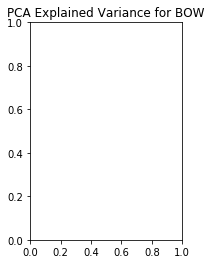

In [29]:
plt.subplot(121)
plt.title("PCA Explained Variance for BOW")
plt.plot(np.cumsum(pca_bow.explained_variance_ratio_))
plt.subplot(122)
plt.title("PCA Explained Variance for TFID")
plt.plot(np.cumsum(pca_bow.explained_variance_ratio_))
plt.show()

## Truncated SVD
| number of components |  50  | 100 | 150 |
|----------------------|------|-----|-----|
|   explained variance | 0.35 | 0.50| tbd |


Note 150 components takes a long time. Benefit over PCA: PCA could potentially work but BOW and TFIDF create sparse matrices, which makes PCA unusable (b/c of large matrices). Plus, you do not need to standard scale using TruncatedSVD

In [3]:
from sklearn.decomposition import TruncatedSVD
tsvd_bow = TruncatedSVD(n_components=100)
tsvd_bow_npy = tsvd_bow.fit_transform(vec_desc)

In [ ]:
tsvd_tfid = TruncatedSVD(n_components=100)
tsvd_tfid_npy = tsvd_tfid.fit_transform(tfid_desc)

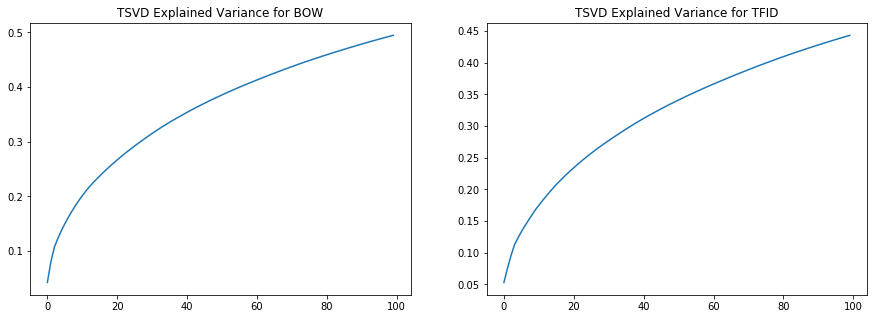

In [10]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title("TSVD Explained Variance for BOW")
plt.plot(np.cumsum(tsvd_bow.explained_variance_ratio_))
plt.subplot(122)
plt.title("TSVD Explained Variance for TFID")
plt.plot(np.cumsum(tsvd_tfid.explained_variance_ratio_))
plt.show()

In [ ]:
from joblib import dump, load
dump(tsvd_bow, 'models/tsvd_bow.joblib')
dump(tsvd_tfid, 'models/tsvd_tfid.joblib')

np.save('datasets/tsvd_bow.npy', tsvd_bow_npy)
np.save('datasets/tsvd_tfid.npy', tsvd_tfid_npy)

In [5]:
# reload
tsvd_tfid_npy = np.load('datasets/tsvd_tfid.npy')
tsvd_bow_npy = np.load('datasets/tsvd_bow.npy')

## LDA

In [ ]:
# 1,000 took 1.37 seconds
# 10,000 took 14.1 seconds

In [124]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import GridSearchCV
search_params = {'n_components': [10, 15, 20, 25, 30]}

lda = LDA(n_components = 10)
lda_bow = lda.fit_transform(vec_desc[:10000])
# model = GridSearchCV(lda, param_grid = search_params)
# model.fit(vec_desc)

In [ ]:
lda = LDA(n_components = 10)
lda_tfid = lda.fit_transform(tfid_desc)

# Clustering
## Kmeans
Note that kmeans cannot take in a sparse matrix, so it must be result of TruncatedSVD/LDA/etc, or you must convert to dense matrix. Interpretation of silhouette: compares average distance to other points within same cluster to that of the nearest other cluster (the higher the silhouette, the better the clustering)

Notes: 5 clusters with 50 parameters, ran for 1 minute and 14 seconds.

silhouette score took too long, so I've abandoned analyzing via silhouette score

| clusters | dimensions | time | silhouette time | data preprocessing |
|----------|------------|------|-----------------|--------------------|
| 5        | 50         | 74sec|     14minutes+  |   TSVD             |


In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
num_clusters = 7
kmeans_bow = [KMeans(n_clusters=x, random_state=0)
              for x in range(3, num_clusters + 1)]
silhou_bow = [0 for x in range(3, num_clusters + 1)]
silhou_ind = [0 for x in range(3, num_clusters + 1)]
for i in range(num_clusters):
    print(i)
    dist_to_clusters = kmeans_bow[i].fit_transform(tsvd_bow_npy[:,:])
    preds = kmeans_bow[i].predict(tsvd_bow_npy[:, :])
    np.random.seed(i)
    choose = np.random.choice(np.arange(tsvd_bow_npy.shape[0]), 10000)
    silhou_bow[i] = silhouette_score(tsvd_bow_npy[choose], preds[choose])
    silhou_ind[i] = choose

0
1
2
3
4
5


IndexError: list index out of range

In [58]:
silhou_bow # took 7minutes 43 seconds

[0.32165693172674165,
 0.33166540320384535,
 0.3416754440777323,
 0.2691255950196097,
 0.23379680186678983]

TSNE
500 data points took 3s

In [15]:
from MulticoreTSNE import MulticoreTSNE as TSNE
bow_embedded = TSNE(n_jobs=4).fit_transform(tsvd_bow_npy[:500, :])

In [27]:
dispensaries = cleaned_weed_text[['dispensary_name']].iloc[:500].values.flatten()
dispensaries = dispensaries.tolist()

In [31]:
name_to_ind = {}
names = []
ct = 0
new_dispensaries = []
for elem in dispensaries:
    if elem not in name_to_ind:
        name_to_ind[elem] = ct
        names.append(elem)
        ct += 1
    new_dispensaries.append(name_to_ind[elem])

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,


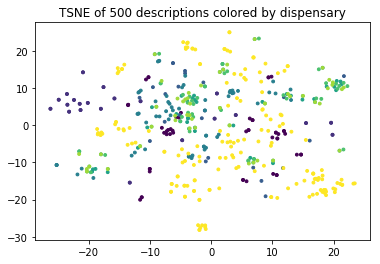

In [40]:
plt.title("TSNE of 500 descriptions colored by dispensary")
plt.scatter(bow_embedded[:, 0], bow_embedded[:, 1], c = new_dispensaries, s = 8.0)
plt.show()

In [59]:
from joblib import dump, load
dump(kmeans_bow, 'models/kmeans_bow.joblib')
dump(silhou_bow, 'models/kmeans_bow_silh.joblib')
dump(silhou_ind, 'models/kmeans_bow_silh_ind.joblib')

['models/kmeans_bow_silh_ind.joblib']

In [ ]:
num_clusters = 10
kmeans_tfid = [Kmeans(n_clusters=x, random_state=0)
               for x in range(1, num_clusters + 1)]
silhou_tfid = [0 for x in range(num_clusters)]
for i in range(num_clusters):
    cluster_labels = kmeans_tfid[i].fit(tsvd_tfid)
    silhou_tfid[i] = silhouette_score(tsvd_tfid, cluster_labels)

## KNN (Unsupervised)

| dimensions | training time | kneighbors time |
|------------|---------------|-----------------|
| 100        | 47.8 sec      | counting        |

In [3]:
cleaned_weed_text = pd.read_csv('datasets/cleaned_desc.csv')

In [6]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(tsvd_bow_npy)

Example 1: $100.00 Oz's nearest neighbors

In [7]:
distances, indices = nbrs.kneighbors(tsvd_bow_npy[:1,:])

In [8]:
close_to_first = indices[0]
cleaned_weed_text.iloc[close_to_first]

,Unnamed: 0,dispensary_name,description,product_name,price_eighth
17,28,$100.00 Oz,Lucifer OG by Karma Genetics is the devilish o...,(Outdoor) Lucifer OG $59.99 oz,0.0
0,0,$100.00 Oz,Lucifer OG by Karma Genetics is the devilish o...,(Outdoor) Lucifer OG $59.99 oz,0.0
34,56,$100.00 Oz,Lucifer OG by Karma Genetics is the devilish o...,(Outdoor) Lucifer OG $59.99 oz,0.0
70689,125676,Botanica - Tucson,(Biker Kush x Amnesia Og) Accompanied with a b...,Where's My Bike?,42.0
554157,869598,Jamestown Yuma,It was created by breeding the Calyx Garden Pi...,Pineapple Cookies,0.0


In [71]:
print('original\n', cleaned_weed_text.iloc[close_to_first]['description'].iloc[0],'\n')
print('comparison1\n', cleaned_weed_text.iloc[close_to_first]['description'].iloc[3], '\n')
print('comparison2\n', cleaned_weed_text.iloc[close_to_first]['description'].iloc[4], '\n')

original
 Lucifer OG by Karma Genetics is the devilish offspring of aHells OGmother and a backcrossedSFV OG Kushmale. Emitting the classic kush aroma of pine and forest floor, this strain tends to grow larger than its parents and offers an ample, resinous harvest after its 9 to 11 week flowering time. Lucifer OGs mid-level euphoria helps dissolve stress while its compounding physical relaxation helps mitigate minor aches and pains. 

comparison1
 (Biker Kush x Amnesia Og) Accompanied with a beautiful fresh aroma, this sativa-dominant strain is great for a cerebral buzz also while relieving stress. 

comparison2
 It was created by breeding the Calyx Garden Pineapple OG Kush father (Poison OG x Purple Pineapple) with the long-lasting body-melter Platinum GSC. Relaxation and happiness creep across the body, gradually dissolving stress and depression as the consumers mood elevates. This strain's aroma is bright and buttery, exhibiting sweet notes from both its parents. 



In [80]:
words_in_orig = set(cleaned_weed_text.iloc[close_to_first]['description'].iloc[0].lower().split(" "))
words_in_new1 = set(cleaned_weed_text.iloc[close_to_first]['description'].iloc[3].lower().split(" "))
words_in_new2 = set(cleaned_weed_text.iloc[close_to_first]['description'].iloc[4].lower().split(" "))
words_in_orig.intersection(words_in_new1), words_in_orig.intersection(words_in_new2)

({'a', 'is', 'kush', 'strain', 'this', 'while'},
 {'and',
  'aroma',
  'by',
  'is',
  'its',
  'kush',
  'og',
  'relaxation',
  'stress',
  'the',
  'this'})

Example 2

In [63]:
distances1, indices1 = nbrs.kneighbors(tsvd_bow_npy[100:101,:])

In [66]:
cleaned_weed_text.iloc[indices1[0]]

,Unnamed: 0,dispensary_name,description,product_name,price_eighth
100,177,1 LOVE SERVICES,"Master Kush, MK, is a popular indica cross bet...",Master Kush,40.0
752616,1172831,WEED MONKEY,Bubba Star is an Indica cross between Star Kus...,Bubba Star AAAA,33.0
752268,1172478,WEED MONKEY,Bubba Star is an Indica cross between Star Kus...,Bubba Star AAAA,33.0
752062,1172269,WEED MONKEY,Bubba Star is an Indica cross between Star Kus...,Bubba Star AAAA,33.0
752477,1172690,WEED MONKEY,Bubba Star is an Indica cross between Star Kus...,Bubba Star AAAA,33.0


In [72]:
print('original\n', cleaned_weed_text.iloc[indices1[0]]['description'].iloc[0],'\n')
print('comparison1\n', cleaned_weed_text.iloc[indices1[0]]['description'].iloc[3], '\n')

original
 Master Kush, MK, is a popular indica cross between Hindu Kush and Skunk, Its aroma is nearly undetectable, but it produces a subtle earthy, citrus taste. With MK, you can anticipate full-body relaxation coupled with sharpened sensory awareness that can bring out the best of any activity. 

comparison1
 Bubba Star is an Indica cross between Star Kush and Bubba Kush. 



In [79]:
words_in_orig = set(cleaned_weed_text.iloc[indices1[0]]['description'].iloc[0].lower().split(" "))
words_in_new1 = set(cleaned_weed_text.iloc[indices1[0]]['description'].iloc[3].lower().split(" "))
words_in_orig.intersection(words_in_new1)

{'and', 'between', 'cross', 'indica', 'is', 'kush'}